In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import iisignature as iisig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *

In [2]:
key = 'single_key'
sample_len = 30

In [54]:
with open(f'./data/dataframes/{key}/dfs.pkl', 'rb') as f:
    dfs = pickle.load(f)
len(dfs)

802

In [4]:
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform(dfs)
dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, stride=10000)
len(dataset) == len(dfs)

True

In [11]:
X = []
for i in range(len(dataset)):
    X.append(dataset[i])
X = torch.stack(X)
X = batch_rectilinear_with_gap_transform(X)
Xs = X.numpy()
Xs.shape, X.shape

((802, 60, 2), torch.Size([802, 60, 2]))

In [12]:
signatures = []
for path in Xs:
    signatures.append(iisig.sig(path, 5))
signatures = np.array(signatures)
signatures.shape

(802, 62)

In [13]:
cluster.KMeans(n_clusters=4).fit(signatures).labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=1.0)
kernel = ksig.kernels.SignatureKernel(n_levels=5, order=1, normalization=0, static_kernel=static_kernel, device_ids=None)

In [20]:
# calculate gram matrix in batches
batch_size = 50
gram_matrix = torch.empty(len(X), len(X))
for i in range(int(len(X) / batch_size)+1):
    gram_matrix[i*batch_size:(i+1)*batch_size] = kernel(X[i*batch_size:(i+1)*batch_size], X)

In [33]:
zero_diag_gram = gram_matrix.clone()
for i in range(len(X)):
    zero_diag_gram[i,i] = 0

<Axes: >

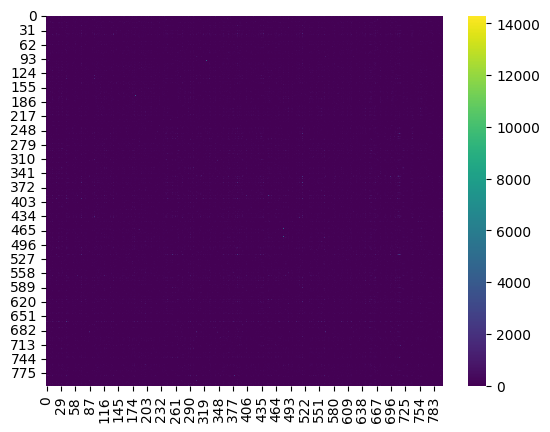

In [35]:
sns.heatmap(zero_diag_gram.numpy(), cmap='viridis')

In [39]:
# get coordinates (x,y) of highest values in gram matrix
n = 10
coords = []
values = []
temp_matrix = zero_diag_gram.clone()
for i in range(n):
    coords.append(torch.argmax(temp_matrix).item())
    values.append(torch.max(temp_matrix).item())
    temp_matrix[coords[-1]//len(X), coords[-1]%len(X)] = 0
coords = [(c//len(X), c%len(X)) for c in coords]
coords

[(563, 486),
 (486, 563),
 (245, 662),
 (662, 245),
 (389, 486),
 (486, 389),
 (168, 169),
 (169, 168),
 (460, 478),
 (460, 479)]

In [50]:
# get coordinates (x,y) of lowest values in gram matrix
n = 10
coords = []
values = []
temp_matrix = zero_diag_gram.clone()
for i in range(n):
    coords.append(torch.argmin(temp_matrix).item())
    values.append(torch.min(temp_matrix).item())
    temp_matrix[coords[-1]//len(X), coords[-1]%len(X)] = np.inf
coords = [(c//len(X), c%len(X)) for c in coords]
coords

[(303, 294),
 (294, 303),
 (303, 526),
 (526, 303),
 (282, 303),
 (303, 282),
 (33, 303),
 (303, 33),
 (457, 303),
 (303, 457)]

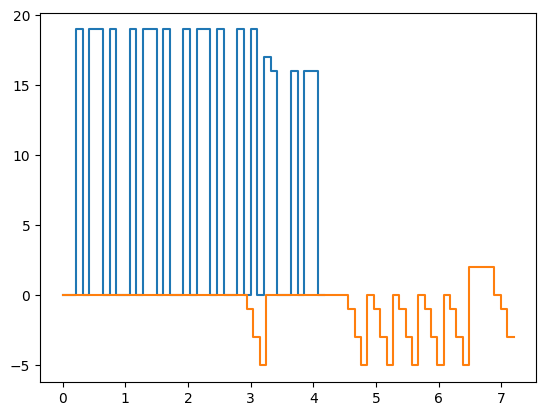

In [51]:
sample_1 = 303
sample_2 = 294
plt.plot(X[sample_1,:,0],X[sample_1,:,1])
plt.plot(X[sample_2,:,0],X[sample_2,:,1])

/home/luchungi/miniconda3/envs/music/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(array([266., 354., 135.,  47.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

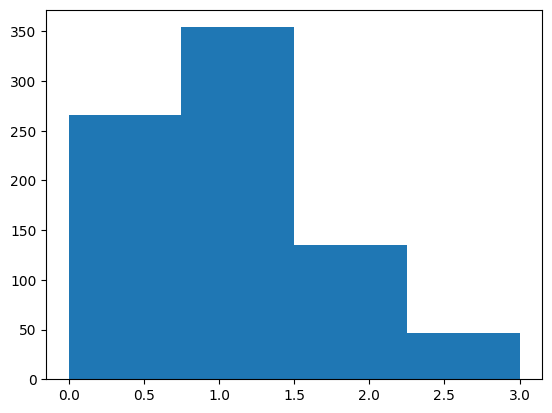

In [78]:
n_clusters = 4
labels = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(gram_matrix).labels_
plt.hist(labels, bins=n_clusters)

(array([11., 11., 24., 22.,  1.,  4., 15.,  7., 10.,  4.,  6.,  5., 14.,
         2., 19.,  3.,  9.,  6., 92.,  7., 16.,  7.,  5., 14.,  9., 15.,
         5., 10.,  8., 22.,  1.,  1.,  8., 11., 29.,  9.,  5., 49.,  3.,
        13.,  4., 59.,  6., 13.,  3.,  8., 31., 27.,  2., 77., 15.,  9.,
         5.,  8.,  8., 12.,  3.]),
 array([ 0.        ,  0.98245614,  1.96491228,  2.94736842,  3.92982456,
         4.9122807 ,  5.89473684,  6.87719298,  7.85964912,  8.84210526,
         9.8245614 , 10.80701754, 11.78947368, 12.77192982, 13.75438596,
        14.73684211, 15.71929825, 16.70175439, 17.68421053, 18.66666667,
        19.64912281, 20.63157895, 21.61403509, 22.59649123, 23.57894737,
        24.56140351, 25.54385965, 26.52631579, 27.50877193, 28.49122807,
        29.47368421, 30.45614035, 31.43859649, 32.42105263, 33.40350877,
        34.38596491, 35.36842105, 36.35087719, 37.33333333, 38.31578947,
        39.29824561, 40.28070175, 41.26315789, 42.24561404, 43.22807018,
        44.21052

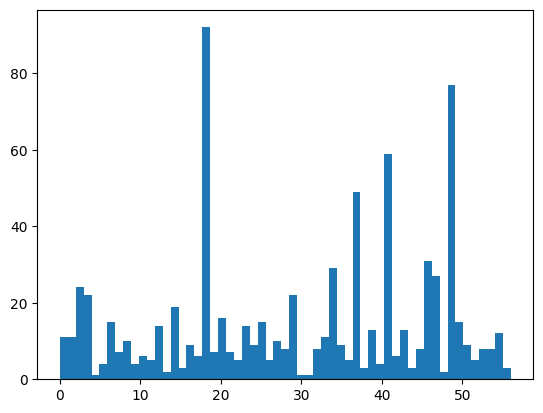

In [72]:
labels = cluster.AffinityPropagation(affinity='precomputed').fit(gram_matrix).labels_
plt.hist(labels, bins=len(np.unique(labels)))

(array([799.,   1.,   1.,   1.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

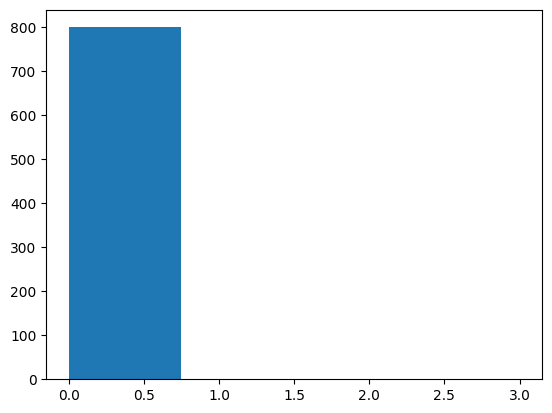

In [68]:
n_clusters = 4
labels = cluster.AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average').fit(gram_matrix).labels_
plt.hist(labels, bins=n_clusters)

In [74]:
eps = np.median(gram_matrix)
labels = cluster.DBSCAN(eps=eps, metric='precomputed').fit(gram_matrix).labels_
plt.hist(labels, bins=len(np.unique(labels)))

ValueError: Negative values in data passed to precomputed distance matrix.

In [76]:
(gram_matrix < 0).sum()

tensor(16)